# D81-1
* **請比較使用 l1, L2, l1_l2 及不同比例下的訓練結果**

In [3]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Using TensorFlow backend.


In [4]:
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.regularizers import l2
"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [9]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0729 20:13:53.877088 140476541249280 deprecation_wrapper.py:119] From /home/rex/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0729 20:13:53.877863 140476541249280 deprecation_wrapper.py:119] From /home/rex/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0729 20:13:53.895046 140476541249280 deprecation_wrapper.py:119] From /home/rex/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 20:13:53.895672 140476541249280 deprecation_wrapper.py:119] From /home/rex/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0729 20:13:54.155274 140476541249280 deprecation.py:323] From /home/rex/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 120us/step - loss: 15.0571 - acc: 0.2761 - val_loss: 13.9415 - val_acc: 0.3395
Epoch 2/50
50000/50000 [==============================] - 6s 112us/step - loss: 13.0038 - acc: 0.3582 - val_loss: 12.1140 - val_acc: 0.3701
Epoch 3/50
50000/50000 [==============================] - 6s 113us/step - loss: 11.3328 - acc: 0.3824 - val_loss: 10.5837 - val_acc: 0.3917
Epoch 4/50
50000/50000 [==============================] - 6s 114us/step - loss: 9.9206 - acc: 0.3978 - val_loss: 9.2789 - val_acc: 0.4055
Epoch 5/50
50000/50000 [==============================] - 6s 114us/step - loss: 8.7217 - acc: 0.4079 - val_loss: 8.1767 - val_acc: 0.4083
Epoch 6/50
50000/50000 [==============================] - 5s 109us/step - loss: 7.7002 - acc: 0.4142 - val_loss: 7.2463 - val_acc: 0.4097
Epoch 7/50
50000/50000 [==============================] - 6s 112us/step - loss: 6.8296 - acc: 0.4228 - val_loss: 6.4

Epoch 2/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.9410 - acc: 0.3679 - val_loss: 1.8985 - val_acc: 0.3837
Epoch 3/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.8591 - acc: 0.3986 - val_loss: 1.8342 - val_acc: 0.4068
Epoch 4/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.7986 - acc: 0.4190 - val_loss: 1.7763 - val_acc: 0.4251
Epoch 5/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.7514 - acc: 0.4367 - val_loss: 1.7441 - val_acc: 0.4389
Epoch 6/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.7130 - acc: 0.4493 - val_loss: 1.7102 - val_acc: 0.4479
Epoch 7/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.6793 - acc: 0.4604 - val_loss: 1.6801 - val_acc: 0.4569
Epoch 8/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.6499 - acc: 0.4719 - val_loss: 1.6696 - val_acc: 0.4589
Epoch 9/50
50000/50000 [==========

50000/50000 [==============================] - 6s 128us/step - loss: 1.7302 - acc: 0.3967 - val_loss: 1.7001 - val_acc: 0.4044
Epoch 4/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.6725 - acc: 0.4163 - val_loss: 1.6476 - val_acc: 0.4216
Epoch 5/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6246 - acc: 0.4333 - val_loss: 1.6113 - val_acc: 0.4390
Epoch 6/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.5855 - acc: 0.4463 - val_loss: 1.5813 - val_acc: 0.4394
Epoch 7/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5494 - acc: 0.4590 - val_loss: 1.5472 - val_acc: 0.4532
Epoch 8/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.5192 - acc: 0.4679 - val_loss: 1.5279 - val_acc: 0.4581
Epoch 9/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.4924 - acc: 0.4768 - val_loss: 1.5046 - val_acc: 0.4649
Epoch 10/50
50000/50000 [====================

50000/50000 [==============================] - 7s 132us/step - loss: 1.6630 - acc: 0.4199 - val_loss: 1.6349 - val_acc: 0.4326
Epoch 5/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.6156 - acc: 0.4337 - val_loss: 1.5965 - val_acc: 0.4436
Epoch 6/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.5739 - acc: 0.4501 - val_loss: 1.5797 - val_acc: 0.4475
Epoch 7/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5406 - acc: 0.4607 - val_loss: 1.5499 - val_acc: 0.4596
Epoch 8/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5106 - acc: 0.4706 - val_loss: 1.5159 - val_acc: 0.4684
Epoch 9/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.4821 - acc: 0.4802 - val_loss: 1.4953 - val_acc: 0.4716
Epoch 10/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.4558 - acc: 0.4886 - val_loss: 1.4817 - val_acc: 0.4766
Epoch 11/50
50000/50000 [===================

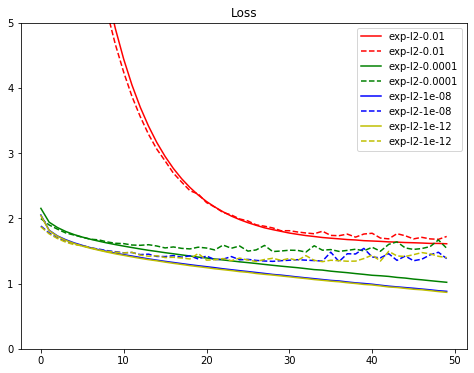

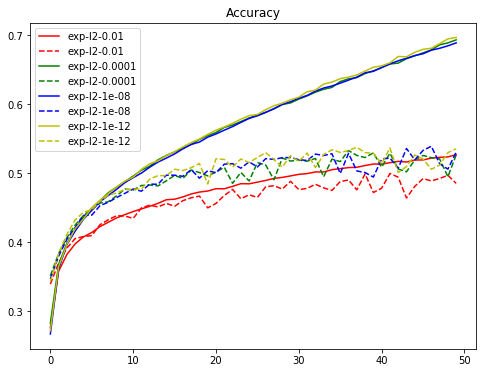

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [11]:
from keras.regularizers import l1
"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [13]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 138us/step - loss: 5.9888 - acc: 0.2801 - val_loss: 5.8076 - val_acc: 0.3495
Epoch 2/50
50000/50000 [==============================] - 6s 127us/step - loss: 5.7207 - acc: 0.3656 - val_loss: 5.6396 - val_acc: 0.3841
Epoch 3/50
50000/50000 [==============================] - 6s 123us/step - loss: 5.5740 - acc: 0.3940 - val_loss: 5.5240 - val_acc: 0.3990
Epoch 4/50
50000/50000 [==============================] - 7s 137us/step - loss: 5.4519 - acc: 0.4154 - val_loss: 5.3978 - val_acc: 0.4272
Epoch 5/50
50000/50000 [==============================] - 6s 125us/step - loss: 5.3423 - acc: 0.4313 - val_loss: 5.3068 - val_acc: 0.4246
Epoch 6/50
50000/50000 [==============================] - 6s 122us/step - loss: 5.2430 - acc: 0.4412 - val_loss: 5.2038 - val_acc: 0.4454
Epoch 7/50
50000/50000 [==============================] - 6s 122us/step - loss: 5.1498 - acc: 0.4527 - val_loss: 5.1094 - 

Epoch 2/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.8187 - acc: 0.3585 - val_loss: 1.7694 - val_acc: 0.3749
Epoch 3/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.7322 - acc: 0.3928 - val_loss: 1.7011 - val_acc: 0.4013
Epoch 4/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.6710 - acc: 0.4162 - val_loss: 1.6445 - val_acc: 0.4272
Epoch 5/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.6232 - acc: 0.4318 - val_loss: 1.6117 - val_acc: 0.4365
Epoch 6/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5833 - acc: 0.4452 - val_loss: 1.5764 - val_acc: 0.4484
Epoch 7/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5489 - acc: 0.4590 - val_loss: 1.5557 - val_acc: 0.4545
Epoch 8/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5195 - acc: 0.4684 - val_loss: 1.5224 - val_acc: 0.4668
Epoch 9/50
50000/50000 [==========

50000/50000 [==============================] - 7s 132us/step - loss: 1.7087 - acc: 0.4007 - val_loss: 1.6760 - val_acc: 0.4125
Epoch 4/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.6504 - acc: 0.4189 - val_loss: 1.6324 - val_acc: 0.4294
Epoch 5/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.6061 - acc: 0.4347 - val_loss: 1.6070 - val_acc: 0.4301
Epoch 6/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.5678 - acc: 0.4500 - val_loss: 1.5696 - val_acc: 0.4423
Epoch 7/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.5363 - acc: 0.4597 - val_loss: 1.5504 - val_acc: 0.4481
Epoch 8/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5079 - acc: 0.4713 - val_loss: 1.5260 - val_acc: 0.4579
Epoch 9/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.4810 - acc: 0.4786 - val_loss: 1.5054 - val_acc: 0.4606
Epoch 10/50
50000/50000 [====================

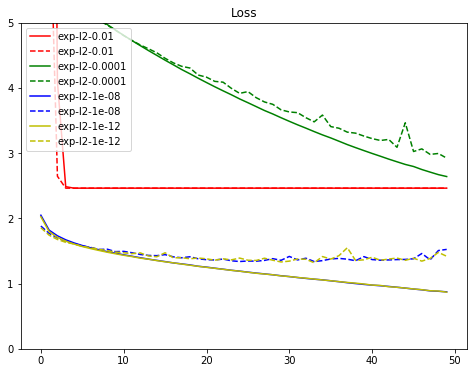

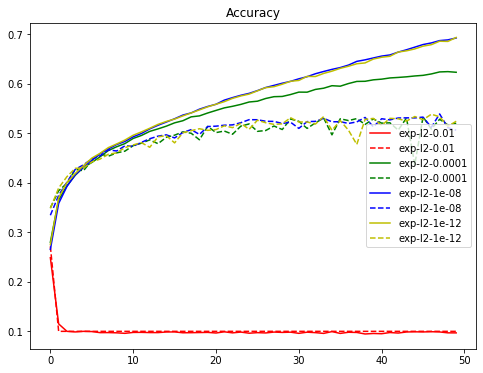

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [15]:
from keras.regularizers import l1_l2
"""
建立神經網路，並加入 L1_L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [17]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 152us/step - loss: 18.8425 - acc: 0.2638 - val_loss: 17.3891 - val_acc: 0.3330
Epoch 2/50
50000/50000 [==============================] - 7s 137us/step - loss: 16.1649 - acc: 0.3512 - val_loss: 14.9985 - val_acc: 0.3614
Epoch 3/50
50000/50000 [==============================] - 7s 138us/step - loss: 13.9745 - acc: 0.3734 - val_loss: 12.9845 - val_acc: 0.3822
Epoch 4/50
50000/50000 [==============================] - 7s 137us/step - loss: 12.1228 - acc: 0.3883 - val_loss: 11.2828 - val_acc: 0.4032
Epoch 5/50
50000/50000 [==============================] - 7s 139us/step - loss: 10.5508 - acc: 0.3970 - val_loss: 9.8408 - val_acc: 0.3997
Epoch 6/50
50000/50000 [==============================] - 7s 137us/step - loss: 9.2120 - acc: 0.4048 - val_loss: 8.6062 - val_acc: 0.4096
Epoch 7/50
50000/50000 [==============================] - 7s 138us/step - loss: 8.0718 - acc: 0.4109 - val_loss: 

Epoch 2/50
50000/50000 [==============================] - 7s 138us/step - loss: 13.0198 - acc: 0.3602 - val_loss: 12.1276 - val_acc: 0.3741
Epoch 3/50
50000/50000 [==============================] - 7s 139us/step - loss: 11.3485 - acc: 0.3806 - val_loss: 10.5968 - val_acc: 0.3927
Epoch 4/50
50000/50000 [==============================] - 7s 138us/step - loss: 9.9367 - acc: 0.3948 - val_loss: 9.2973 - val_acc: 0.4003
Epoch 5/50
50000/50000 [==============================] - 7s 137us/step - loss: 8.7370 - acc: 0.4062 - val_loss: 8.1940 - val_acc: 0.4105
Epoch 6/50
50000/50000 [==============================] - 7s 138us/step - loss: 7.7146 - acc: 0.4123 - val_loss: 7.2526 - val_acc: 0.4113
Epoch 7/50
50000/50000 [==============================] - 7s 139us/step - loss: 6.8427 - acc: 0.4194 - val_loss: 6.4468 - val_acc: 0.4231
Epoch 8/50
50000/50000 [==============================] - 7s 139us/step - loss: 6.0993 - acc: 0.4248 - val_loss: 5.7605 - val_acc: 0.4301
Epoch 9/50
50000/50000 [======

50000/50000 [==============================] - 7s 136us/step - loss: 11.3547 - acc: 0.3806 - val_loss: 10.6045 - val_acc: 0.3867
Epoch 4/50
50000/50000 [==============================] - 7s 136us/step - loss: 9.9414 - acc: 0.3949 - val_loss: 9.3086 - val_acc: 0.3928
Epoch 5/50
50000/50000 [==============================] - 8s 152us/step - loss: 8.7399 - acc: 0.4068 - val_loss: 8.1954 - val_acc: 0.4065
Epoch 6/50
50000/50000 [==============================] - 7s 137us/step - loss: 7.7160 - acc: 0.4132 - val_loss: 7.2510 - val_acc: 0.4182
Epoch 7/50
50000/50000 [==============================] - 7s 138us/step - loss: 6.8435 - acc: 0.4201 - val_loss: 6.4494 - val_acc: 0.4235
Epoch 8/50
50000/50000 [==============================] - 7s 136us/step - loss: 6.0965 - acc: 0.4270 - val_loss: 5.7579 - val_acc: 0.4247
Epoch 9/50
50000/50000 [==============================] - 7s 136us/step - loss: 5.4610 - acc: 0.4308 - val_loss: 5.1771 - val_acc: 0.4335
Epoch 10/50
50000/50000 [==================

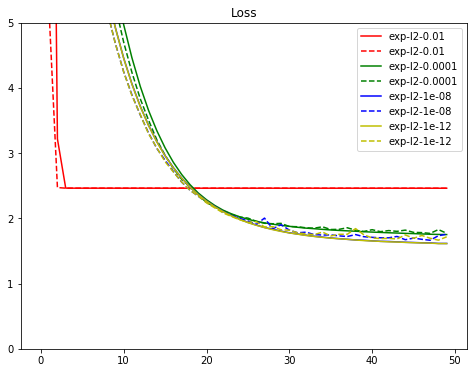

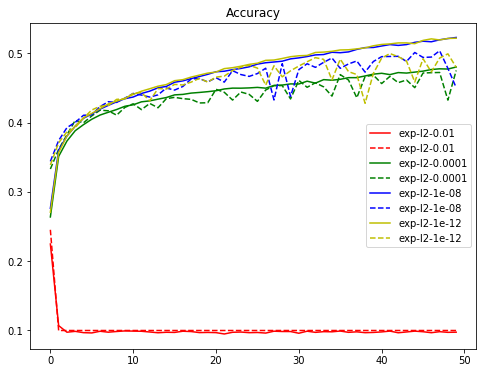

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()